In [30]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import spock
from spock import FeatureClassifier
import corner
from tqdm import tqdm
from scipy import stats
from celmech import Andoyer
from statsmodels.stats.weightstats import DescrStatsW
import warnings
import rebound
import timeit
import sys
from multiprocessing import Pool
import multiprocessing
from p_tqdm import p_map
from multiprocessing import Pool
warnings.simplefilter(action='ignore', category=FutureWarning)
import glob

In [48]:
obs_idx

[0, 199]

In [47]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0]
delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index]

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs = np.array([1.503, 1.503])

def makesim(theta):


    e_forced, e_free, mu, deltaT, mb, eb, pomegab, thetab = theta

    mratio=0.5
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    theta1 = np.pi
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # position of planet b

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi,
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2,
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:

        sim = andvars.to_Simulation()
        sim.add(m=mb, P=sim.particles[2].P*1.946, e=eb, pomega=pomegab, theta=thetab)
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except KeyboardInterrupt:
        print('Interrupted')
        print(e_forced, e_free, mu, deltaT, mb, eb, pomegab, thetab)
        raise

def run(sim):

    Pratios = np.zeros(Nout)
    ps = sim.particles

    for i, time in enumerate(t):

        sim.integrate(time)
        Pratios[i] = ps[2].P/ps[1].P

    return Pratios

def compute_model(theta):

    sim = makesim(theta)
    period_ratios = run(sim)
    return period_ratios[obs_idx]

def gen_priors_array(seed):

    #size_arr = int(n)

    rng = np.random.default_rng(seed)

    eforced_0 = float(rng.uniform(0.0005,0.23,size=1)) # changing the upper limit to the crossing eccentricity
    efree_0 = float(rng.uniform(0.0005,0.003,size=1)) # changing the bounds because experiments show that
    mu_0 = float(rng.uniform(np.log10(8.964e-6), np.log10(5.25e-4), size=1)) # new upper limit of 0.55 Mjup by Mascareno

    #mb_0 = stats.norm.rvs(loc=0.69, scale=0.19, size=size_arr)*9.54e-4
    mb_0 = float(stats.truncnorm.rvs(a=(0 - 0.69)/0.19, b = np.inf, loc=0.69, scale=0.19, size=1))*9.54e-4
    #eb_0 = stats.norm.rvs(loc=0.13, scale=0.07, size=size_arr)
    eb_0 = float(stats.truncnorm.rvs(a = (0 - 0.13)/0.07, b = np.inf, loc=0.13, scale=0.07, size=1))
    pomegab_0 = float(np.random.uniform(0, 2*np.pi, size=1))

    thetab_0 = float(np.random.uniform(0, 2*np.pi, size=1))

    deltaT_0 = float(rng.uniform(0, 2000, size=1))

    prior_set = (eforced_0, efree_0, mu_0, deltaT_0, mb_0, eb_0, pomegab_0, thetab_0)

    return prior_set

def lnlike(theta):

    model = compute_model(theta)
    argument = (obs - model)**2 / obs_err**2
    loglike = 0.5*np.sum(argument)
    return loglike

def get_posteriors(seed):

    prior = gen_priors_array(seed)
    like_val = lnlike(prior)

    rng = np.random.default_rng(seed)

    prob = np.log10(np.random.random())


    if -like_val > prob:
        post = prior

        return post

    else:
    	return np.nan

In [14]:
seeds = list(range(0, 1000))
prior_test = np.array([gen_priors_array(seed) for seed in seeds])

In [15]:
likes = [lnlike(prior) for prior in tqdm(prior_test)]
np.min(likes)


 22%|██▏       | 221/1000 [00:04<00:15, 51.29it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/rebound/simulation.py:712: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)

 88%|████████▊ | 878/1000 [00:16<00:02, 51.56it/s]


100%|██████████| 1000/1000 [00:19<00:00, 51.19it/s][A


92433.12935419603

In [17]:
if __name__ == '__main__':
    pool = Pool(processes=3)
    results = pool.map(lnlike, prior_test)
    pool.close()
    pool.join()
    print(results)

KeyboardInterrupt: 

In [6]:
#start_time = timeit.default_timer()
post_test = np.array([get_posteriors(seeds) for seed in tqdm(seeds)])
print(len(post_test))
print(len(post_test[~np.isnan(post_test)]))
#print('Elapsed time:',timeit.default_timer() - start_time)

  0%|          | 12/10000 [00:00<10:36, 15.70it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/rebound/simulation.py:712: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)
100%|██████████| 10000/10000 [10:48<00:00, 15.42it/s]

10000
0


In [7]:
start_time = timeit.default_timer()
post_test = np.array(get_posteriors(0, 1e5))
#res = post_test[~np.isnan(post_test)]
print(len(post_test))
print('Elapsed time:',timeit.default_timer() - start_time)

96891
Elapsed time: 1412.801735845


In [8]:
res = post_test[~np.isnan(post_test)]
res

array([], dtype=float64)

In [159]:
mbs = [prior[4] for prior in prior_test]
ebs = [prior[5] for prior in prior_test]

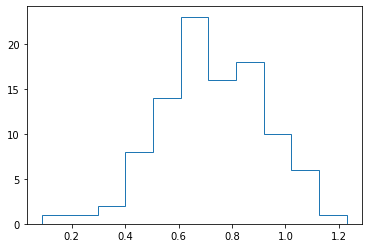

In [160]:
%matplotlib inline
plt.hist(np.array(mbs), bins='auto',histtype='step')
plt.show()

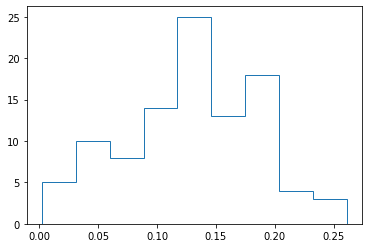

In [161]:
plt.hist(np.array(ebs), bins='auto', histtype='step')
plt.show()

In [35]:
0.64+3*0.19

1.21

In [24]:
multiprocessing.cpu_count()

12

In [26]:
seeds = list(range(0, int(1e3)))

In [28]:
gen_priors_array(29398)

(0.08773406792691354,
 0.0026700405706465108,
 -3.598086120196692,
 351.0607493553803,
 0.8310181667954045,
 0.0005722129008480237,
 1.620644702096331,
 1.3666576996122295)

# Reading the files

In [31]:
path = '/Users/Helios/gdrive_pu/tamayo_research/lnlike_planetb/'
params = [np.load(file, allow_pickle=True) for file in glob.iglob(path+'/*.npy', recursive=True)]

par_con = np.concatenate(params)
print(len(par_con))

like_output = par_con[pd.notnull(par_con)]

print(len(like_output))

#params = [list(like_output[i][:2]) for i in range(len(like_output))]
#mus = [np.log10((10**like_output[i][-1])/9.54e-4) for i in range(len(like_output))]
#mus = [like_output[i][-1] for i in range(len(like_output))]
#deltaTs = [like_output[i][2] for i in range(len(like_output))]

#like_output = []

#for p,mu,T in zip(params,mus,deltaTs):
#    r = list(p)
#    r.append(mu)
#    r.append(T)
    
#    like_output.append(r)

100000
37


In [32]:
like_output[0]

(0.083807332676382,
 0.002881934595396515,
 -4.851220271043249,
 609.1676146384888,
 0.000759346093748633,
 0.10156559676845495,
 2.1597379344627727,
 0.3384444848439454)

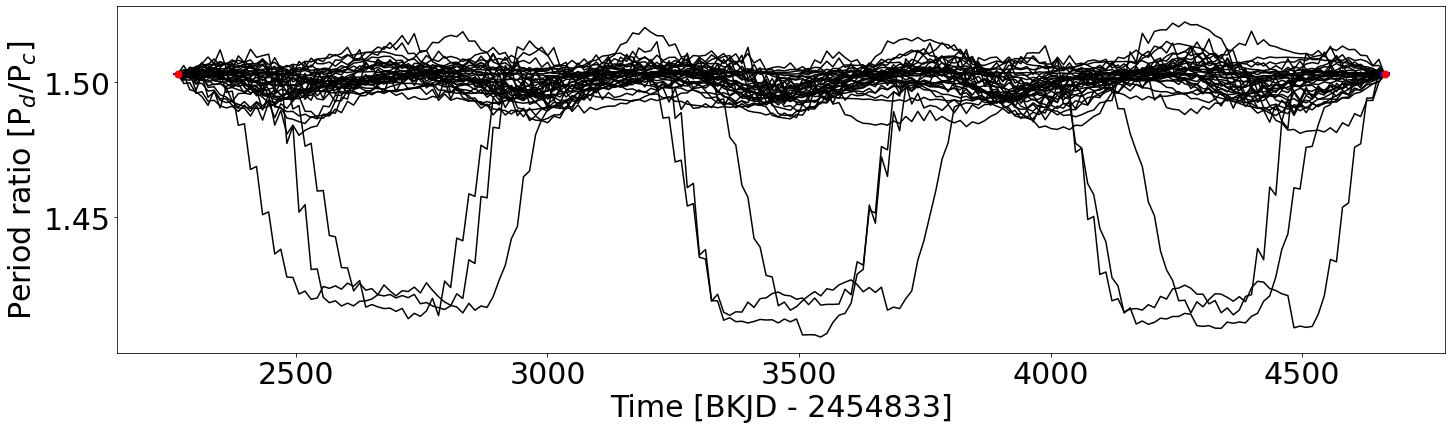

In [54]:
%matplotlib inline
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in enumerate(like_output):
    p = param
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax.plot(time_grid,period_ratios,
         alpha=1.0,zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=30)
#ax.set_ylim(1.493, 1.510)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

In [66]:
Pratios = np.zeros(Nout)
sim = makesim(like_output[0])
ps = sim.particles

for i, time in enumerate(t):

    sim.integrate(time)
    Pratios[i] = ps[3].P/ps[2].P

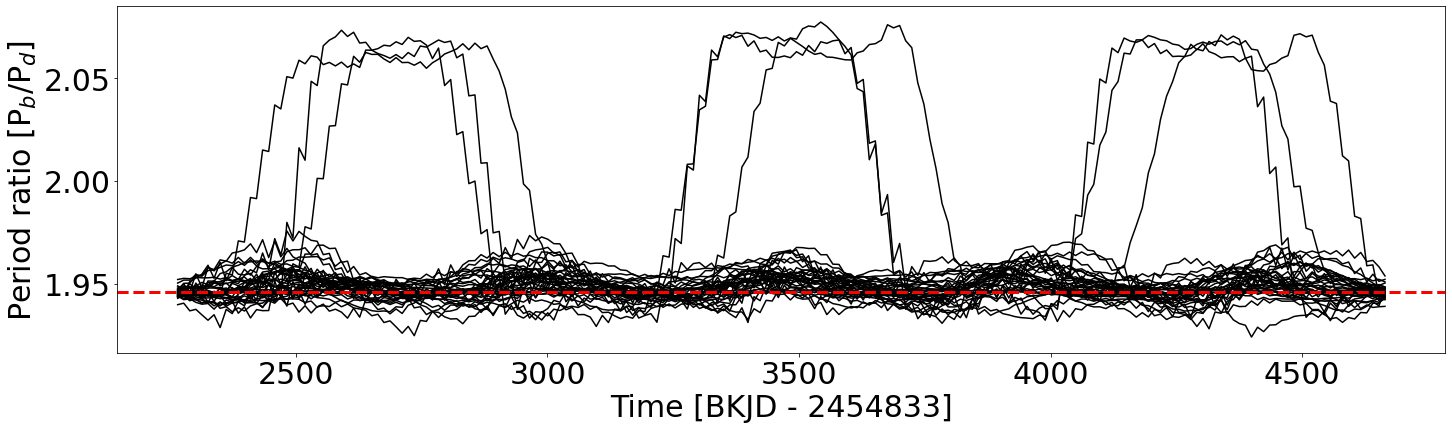

In [132]:
%matplotlib inline
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in enumerate(like_output):
    p = param
    
    sim = makesim(p)
    ps = sim.particles
    Pratios = np.zeros(Nout)
    for i, time in enumerate(t):

        sim.integrate(time)
        Pratios[i] = ps[3].P/ps[2].P
    
    ax.plot(time_grid,Pratios,
         alpha=1.0,zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

#ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_b$/P$_d$]',fontsize=30)
#ax.set_ylim(1.93, 1.97)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)
ax.axhline(y=1.946, lw=3, ls='--', c='r')

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

In [69]:
first = []
last = []
for i,param in enumerate(like_output):
    p = param
    
    sim = makesim(p)
    ps = sim.particles
    Pratios = np.zeros(Nout)
    for i, time in enumerate(t):

        sim.integrate(time)
        Pratios[i] = ps[3].P/ps[2].P
    first.append(Pratios[0])
    last.append(Pratios[-1])

In [76]:
np.median(first)

1.9455544243555654

In [77]:
np.median(last)

1.945804892499194

In [73]:
np.std(first)

0.0021398081056220367

In [74]:
np.std(last)

0.002861663853457357

# Adding the criteria that Pb/Pd should pass through observations

In [101]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0]
delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index]

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs_err_db = np.array([0.0001, 0.0004])
obs = np.array([1.503, 1.503])
obs_db = np.array([1.946, 1.946])

def makesim(theta):


    e_forced, e_free, mu, deltaT, mb, eb, pomegab, thetab = theta

    mratio=0.5
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    theta1 = np.pi
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # position of planet b

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi,
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2,
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:

        sim = andvars.to_Simulation()
        sim.add(m=mb, P=sim.particles[2].P*1.946, e=eb, pomega=pomegab, theta=thetab)
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except KeyboardInterrupt:
        print('Interrupted')
        print(e_forced, e_free, mu, deltaT, mb, eb, pomegab, thetab)
        raise

def run(sim):

    Pratios_cd = np.zeros(Nout)
    Pratios_db = np.zeros(Nout)
    ps = sim.particles

    for i, time in enumerate(t):

        sim.integrate(time)
        Pratios_cd[i] = ps[2].P/ps[1].P
        Pratios_db[i] = ps[3].P/ps[2].P

    return Pratios_cd, Pratios_db

def gen_priors_array(seed):

    #size_arr = int(n)

    rng = np.random.default_rng(seed)

    eforced_0 = float(rng.uniform(0.0005,0.23,size=1)) # changing the upper limit to the crossing eccentricity
    efree_0 = float(rng.uniform(0.0005,0.003,size=1)) # changing the bounds because experiments show that
    mu_0 = float(rng.uniform(np.log10(8.964e-6), np.log10(5.25e-4), size=1)) # new upper limit of 0.55 Mjup by Mascareno

    #mb_0 = stats.norm.rvs(loc=0.69, scale=0.19, size=size_arr)*9.54e-4
    mb_0 = float(stats.truncnorm.rvs(a=(0 - 0.69)/0.19, b = np.inf, loc=0.69, scale=0.19, size=1))*9.54e-4
    #eb_0 = stats.norm.rvs(loc=0.13, scale=0.07, size=size_arr)
    eb_0 = float(stats.truncnorm.rvs(a = (0 - 0.13)/0.07, b = np.inf, loc=0.13, scale=0.07, size=1))
    pomegab_0 = float(np.random.uniform(0, 2*np.pi, size=1))

    thetab_0 = float(np.random.uniform(0, 2*np.pi, size=1))

    deltaT_0 = float(rng.uniform(0, 2000, size=1))

    prior_set = (eforced_0, efree_0, mu_0, deltaT_0, mb_0, eb_0, pomegab_0, thetab_0)

    return prior_set

def compute_model(theta):

    sim = makesim(theta)
    pratios_cd, pratios_db = run(sim)
    return pratios_cd[obs_idx], pratios_db[obs_idx]



def lnlike(theta):

    model_cd, model_db = compute_model(theta)
    argument_cd, argument_db = (obs - model_cd)**2 / obs_err**2, (obs_db - model_db)**2 / obs_err_db**2
    loglike_cd, loglike_db = 0.5*np.sum(argument_cd), 0.5*np.sum(argument_db)
    return loglike_cd, loglike_db

def get_posteriors(seed):

    prior = gen_priors_array(seed)
    like_val = lnlike(prior)

    rng = np.random.default_rng(seed)

    prob = np.log10(np.random.random())


    if -like_val[0] > prob and -like_val[1] > prob:
        post = prior

        return post

    else:
    	return np.nan

In [100]:
lnlikes_db = [lnlike(param)[1] for param in like_output]
print(np.min(lnlikes_db))

0.17132203748232366


In [102]:
seeds = list(range(0, int(1e5)))

#start_time = timeit.default_timer()
post_test = [get_posteriors(seed) for seed in tqdm(seeds)]
print(len(np.array(post_test)[pd.notnull(np.array(post_test))]))

#print('Elapsed time:',timeit.default_timer() - start_time)


  1%|          | 725/100000 [00:16<38:45, 42.70it/s]


  1%|▏         | 1445/100000 [00:33<37:37, 43.66it/s]


  2%|▏         | 2136/100000 [00:50<49:32, 32.92it/s]


  3%|▎         | 2836/100000 [01:06<36:50, 43.96it/s]


  4%|▎         | 3551/100000 [01:23<36:17, 44.30it/s]


  4%|▍         | 4266/100000 [01:39<36:37, 43.57it/s]


  5%|▍         | 4981/100000 [01:56<36:14, 43.69it/s]


  6%|▌         | 5696/100000 [02:12<36:31, 43.03it/s]


  6%|▋         | 6411/100000 [02:29<35:41, 43.69it/s]


  7%|▋         | 7122/100000 [02:46<37:21, 41.44it/s]


  8%|▊         | 7837/100000 [03:03<35:27, 43.32it/s]


  9%|▊         | 8552/100000 [03:19<35:27, 42.99it/s]


  9%|▉         | 9267/100000 [03:36<34:55, 43.29it/s]


 10%|▉         | 9982/100000 [03:52<34:27, 43.54it/s]


 11%|█         | 10687/100000 [04:08<34:41, 42.91it/s]


 11%|█▏        | 11380/100000 [04:25<33:40, 43.86it/s]


 12%|█▏        | 12085/100000 [04:41<32:27, 45.14it/s]


 13%|█▎        | 12790/100000 [04:57<32:28, 44.75it/s]


 13%|█▎        | 13495/100000 [05:13<32:08, 44.85it/s]


 14%|█▍        | 14196/100000 [05:29<33:30, 42.69it/s]


 15%|█▍        | 14901/100000 [05:45<34:08, 41.53it/s]


 16%|█▌        | 15577/100000 [06:01<35:22, 39.77it/s]


 16%|█▋        | 16260/100000 [06:18<31:51, 43.81it/s]


 17%|█▋        | 16965/100000 [06:34<31:58, 43.29it/s]


 18%|█▊        | 17670/100000 [06:50<31:50, 43.10it/s]


 18%|█▊        | 18375/100000 [07:07<31:20, 43.41it/s]


 19%|█▉        | 19063/100000 [07:23<32:35, 41.38it/s]


 20%|█▉        | 19760/100000 [07:40<32:13, 41.49it/s]


 20%|██        | 20462/100000 [07:57<32:31, 40.76it/s]


 21%|██        | 21167/100000 [08:13<30:39, 42.85it/s]


 22%|██▏       | 21872/100000 [08:30<30:15, 43.04it/s]


 23%|██▎       | 22577/100000 [08:46<29:30, 43.74it/s]


 23%|██▎       | 23282/100000 [09:02<29:25, 43.45it/s]


 24%|██▍       | 23987/100000 [09:18<29:09, 43.45it/s]


 25%|██▍       | 24691/100000 [09:35<28:24, 44.19it/s]


 25%|██▌       | 25396/100000 [09:51<28:44, 43.27it/s]


 26%|██▌       | 26089/100000 [10:07<28:19, 43.49it/s]


 27%|██▋       | 26794/100000 [10:23<27:01, 45.13it/s]


 27%|██▋       | 27498/100000 [10:39<27:12, 44.42it/s]


 28%|██▊       | 28203/100000 [10:55<26:54, 44.47it/s]


 29%|██▉       | 28908/100000 [11:11<27:18, 43.39it/s]


 30%|██▉       | 29613/100000 [11:27<26:49, 43.73it/s]


 30%|███       | 30294/100000 [11:43<27:09, 42.78it/s]


 31%|███       | 30999/100000 [12:00<26:13, 43.85it/s]


 32%|███▏      | 31704/100000 [12:16<25:43, 44.25it/s]


 32%|███▏      | 32409/100000 [12:32<26:27, 42.58it/s]


 33%|███▎      | 33114/100000 [12:48<25:56, 42.97it/s]


 34%|███▍      | 33818/100000 [13:05<26:38, 41.39it/s]


 35%|███▍      | 34523/100000 [13:21<25:03, 43.56it/s]


 35%|███▌      | 35228/100000 [13:37<24:42, 43.68it/s]


 36%|███▌      | 35933/100000 [13:54<24:31, 43.54it/s]


 37%|███▋      | 36638/100000 [14:10<24:09, 43.72it/s]


 37%|███▋      | 37343/100000 [14:26<24:05, 43.36it/s]


 38%|███▊      | 38050/100000 [14:43<23:34, 43.81it/s]


 39%|███▉      | 38755/100000 [14:59<23:43, 43.03it/s]


 39%|███▉      | 39460/100000 [15:15<23:53, 42.22it/s]


 40%|████      | 40165/100000 [15:32<24:24, 40.85it/s]


 41%|████      | 40832/100000 [15:48<22:32, 43.76it/s]


 41%|████▏     | 41485/100000 [16:05<25:59, 37.52it/s]


 42%|████▏     | 42189/100000 [16:22<22:01, 43.75it/s]


 43%|████▎     | 42894/100000 [16:38<21:56, 43.39it/s]


 44%|████▎     | 43599/100000 [16:54<21:32, 43.63it/s]


 44%|████▍     | 44304/100000 [17:11<21:17, 43.61it/s]


 45%|████▌     | 45009/100000 [17:27<21:34, 42.48it/s]


 46%|████▌     | 45714/100000 [17:43<21:09, 42.77it/s]


 46%|████▋     | 46419/100000 [17:59<20:39, 43.22it/s]


 47%|████▋     | 47124/100000 [18:16<20:25, 43.14it/s]


 48%|████▊     | 47829/100000 [18:32<20:00, 43.47it/s]


 49%|████▊     | 48534/100000 [18:48<19:41, 43.56it/s]


 49%|████▉     | 49239/100000 [19:04<19:38, 43.06it/s]


 50%|████▉     | 49944/100000 [19:21<19:04, 43.73it/s]


 51%|█████     | 50649/100000 [19:37<18:37, 44.17it/s]


 51%|█████▏    | 51354/100000 [19:53<19:20, 41.93it/s]


 52%|█████▏    | 52059/100000 [20:09<18:23, 43.46it/s]


 53%|█████▎    | 52747/100000 [20:26<19:14, 40.91it/s]


 53%|█████▎    | 53447/100000 [20:42<17:23, 44.63it/s]


 54%|█████▍    | 54152/100000 [20:58<18:35, 41.10it/s]


 55%|█████▍    | 54856/100000 [21:14<17:05, 44.00it/s]


 56%|█████▌    | 55561/100000 [21:30<17:25, 42.49it/s]


 56%|█████▋    | 56254/100000 [21:46<17:32, 41.56it/s]


 57%|█████▋    | 56959/100000 [22:03<16:17, 44.05it/s]


 58%|█████▊    | 57664/100000 [22:19<15:43, 44.87it/s]


 58%|█████▊    | 58369/100000 [22:35<16:11, 42.87it/s]


 59%|█████▉    | 59074/100000 [22:51<15:30, 44.00it/s]


 60%|█████▉    | 59779/100000 [23:08<15:21, 43.63it/s]


 60%|██████    | 60484/100000 [23:24<15:00, 43.90it/s]


 61%|██████    | 61188/100000 [23:40<14:53, 43.42it/s]


 62%|██████▏   | 61893/100000 [23:57<14:26, 44.00it/s]


 63%|██████▎   | 62598/100000 [24:13<14:51, 41.94it/s]


 63%|██████▎   | 63303/100000 [24:29<13:55, 43.93it/s]


 64%|██████▍   | 64008/100000 [24:46<13:49, 43.41it/s]


 65%|██████▍   | 64713/100000 [25:02<13:37, 43.14it/s]


 65%|██████▌   | 65418/100000 [25:18<13:04, 44.10it/s]


 66%|██████▌   | 66123/100000 [25:34<12:56, 43.60it/s]


 67%|██████▋   | 66828/100000 [25:50<12:23, 44.60it/s]


 68%|██████▊   | 67533/100000 [26:07<12:16, 44.10it/s]


 68%|██████▊   | 68225/100000 [26:23<12:03, 43.92it/s]


 69%|██████▉   | 68930/100000 [26:39<12:20, 41.96it/s]


 70%|██████▉   | 69604/100000 [26:56<11:42, 43.26it/s]


 70%|███████   | 70306/100000 [27:12<11:36, 42.62it/s]


 71%|███████   | 71011/100000 [27:29<11:41, 41.32it/s]


 72%|███████▏  | 71716/100000 [27:45<10:27, 45.06it/s]


 72%|███████▏  | 72421/100000 [28:01<10:35, 43.41it/s]


 73%|███████▎  | 73126/100000 [28:17<10:20, 43.28it/s]


 74%|███████▍  | 73831/100000 [28:33<09:49, 44.36it/s]


 75%|███████▍  | 74533/100000 [28:49<09:47, 43.38it/s]


 75%|███████▌  | 75238/100000 [29:06<09:50, 41.93it/s]


 76%|███████▌  | 75943/100000 [29:22<09:21, 42.84it/s]


 77%|███████▋  | 76648/100000 [29:38<08:55, 43.65it/s]


 77%|███████▋  | 77352/100000 [29:55<08:41, 43.42it/s]


 78%|███████▊  | 78057/100000 [30:11<08:17, 44.11it/s]


 79%|███████▉  | 78762/100000 [30:27<08:08, 43.49it/s]


 79%|███████▉  | 79467/100000 [30:43<08:06, 42.18it/s]


 80%|████████  | 80171/100000 [31:00<07:38, 43.22it/s]


 81%|████████  | 80876/100000 [31:16<07:29, 42.53it/s]


 82%|████████▏ | 81581/100000 [31:32<07:02, 43.63it/s]


 82%|████████▏ | 82286/100000 [31:49<06:46, 43.56it/s]


 83%|████████▎ | 82991/100000 [32:05<06:31, 43.48it/s]


 84%|████████▎ | 83696/100000 [32:21<06:19, 43.00it/s]


 84%|████████▍ | 84401/100000 [32:38<05:59, 43.35it/s]


 85%|████████▌ | 85072/100000 [32:54<05:52, 42.29it/s]


 86%|████████▌ | 85774/100000 [33:11<05:38, 42.08it/s]


 86%|████████▋ | 86478/100000 [33:27<05:11, 43.48it/s]


 87%|████████▋ | 87183/100000 [33:44<04:58, 43.00it/s]


 88%|████████▊ | 87888/100000 [34:00<04:35, 44.02it/s]


 89%|████████▊ | 88593/100000 [34:16<04:57, 38.32it/s]


 89%|████████▉ | 89298/100000 [34:33<04:08, 43.03it/s]


 90%|█████████ | 90003/100000 [34:49<03:49, 43.60it/s]


 91%|█████████ | 90708/100000 [35:05<03:31, 43.94it/s]


 91%|█████████▏| 91413/100000 [35:21<03:18, 43.31it/s]


 92%|█████████▏| 92118/100000 [35:38<02:59, 43.97it/s]


 93%|█████████▎| 92823/100000 [35:54<02:48, 42.51it/s]


 94%|█████████▎| 93528/100000 [36:10<02:29, 43.28it/s]


 94%|█████████▍| 94233/100000 [36:26<02:12, 43.49it/s]


 95%|█████████▍| 94938/100000 [36:43<01:54, 44.15it/s]


 96%|█████████▌| 95643/100000 [36:59<01:41, 42.96it/s]


 96%|█████████▋| 96348/100000 [37:15<01:24, 43.39it/s]


 97%|█████████▋| 97053/100000 [37:31<01:07, 43.46it/s]


 98%|█████████▊| 97758/100000 [37:48<00:51, 43.58it/s]


 98%|█████████▊| 98463/100000 [38:04<00:35, 43.30it/s]


 99%|█████████▉| 99168/100000 [38:20<00:18, 44.60it/s]


100%|█████████▉| 99873/100000 [38:37<00:02, 43.05it/s]


100%|██████████| 100000/100000 [38:39<00:00, 43.10it/s][A

1



<ipython-input-102-211a586f6a8b>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(len(np.array(post_test)[pd.notnull(np.array(post_test))]))


## Reading the files from the script

In [191]:
path = '/Users/Helios/gdrive_pu/tamayo_research/lnlike_planetb_pratio/'
params = [np.load(file, allow_pickle=True) for file in glob.iglob(path+'/*.npy', recursive=True)]

par_con = np.concatenate(params)
print(len(par_con))

like_output_pratio = par_con[pd.notnull(par_con)]

print(len(like_output_pratio))

#params = [list(like_output[i][:2]) for i in range(len(like_output))]
#mus = [np.log10((10**like_output[i][-1])/9.54e-4) for i in range(len(like_output))]
#mus = [like_output[i][-1] for i in range(len(like_output))]
#deltaTs = [like_output[i][2] for i in range(len(like_output))]

#like_output = []

#for p,mu,T in zip(params,mus,deltaTs):
#    r = list(p)
#    r.append(mu)
#    r.append(T)
    
#    like_output.append(r)

15900000
5


In [192]:
like_output_pratio

array([(0.010700870700151513, 0.00573685662646428, -4.547114237857121, 1152.9098846437544, 0.00028025756148496736, 0.10024825135134298, 1.6820429279552638, 1.5419281267028788),
       (0.06579971368906373, 0.002199626534343583, -4.061389955910304, 1994.1197141712785, 0.0006540185610114705, 0.04805221816739458, 3.9085081343409995, 1.6907408692994188),
       (0.20629605343328966, 0.0013237401619568818, -5.0196782297358515, 1806.1160892656692, 0.00022791416547695664, 0.1074631361148903, 0.32677852610178765, 4.480873457967183),
       (0.027066408152506393, 0.00578881462430419, -4.629994173747816, 1679.5856432191972, 0.0003795092111341169, 0.08812534272388606, 4.587772058105037, 1.44475639552178),
       (0.11055552554114194, 0.0019248889922466263, -4.34010930336813, 319.2296345539083, 0.00046204774383692927, 0.05087105490259719, 4.029931083551737, 1.2815983161394846)],
      dtype=object)

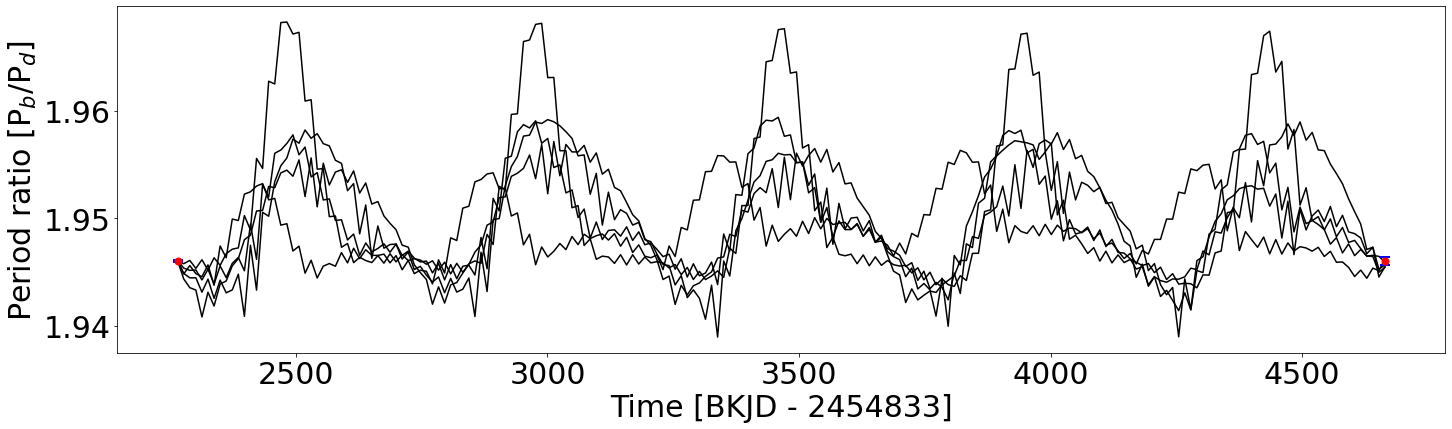

In [189]:
%matplotlib inline
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in enumerate(like_output_pratio):
    p = param
    
    sim = makesim(p)
    ps = sim.particles
    Pratios = np.zeros(Nout)
    for i, time in enumerate(t):

        sim.integrate(time)
        Pratios[i] = ps[3].P/ps[2].P
    
    ax.plot(time_grid,Pratios,
         alpha=1.0,zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs_db,yerr=obs_err_db, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_b$/P$_d$]',fontsize=30)
#ax.set_ylim(1.493, 1.510)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)